In [ ]:
#%pip install torch==2.1.0
#%pip install transformers==4.31.0
#%pip install sentence-transformers==2.2.2
#%pip install pinecone-client==2.2.2
#%pip install datasets==2.14.0
#%pip install langchain==0.0.240
#%pip install bitsandbytes==0.41.0
#%pip install -q -U trl git+https://github.com/huggingface/peft.git
#%pip install -U datasets
#%pip install -U peft trl

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
from datasets import load_dataset

whole_dataset = load_dataset('json', data_files='/root/llama/datasets/preprocessed_dataset.json')

In [45]:

from datasets import load_dataset
# Cleaning function definition
def clean_text(example):
    # Replace newline characters with space
    example['title'] = example['title'].replace('\n', ' ')
    example['summary'] = example['summary'].replace('\n', ' ')
    # Replace apostrophes with empty string
    example['title'] = example['title'].replace('\'', '')
    example['summary'] = example['summary'].replace('\'', '')
    return example

# Application of the cleaning function
cleaned_dataset = whole_dataset['train'].map(clean_text)
print(cleaned_dataset[0:2])

{'summary': ['we propose an architecture for vqa which utilizes recurrent layers to generate visual and textual attention the memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question our single model outperforms the first place winner on the vqa 10 dataset performs within margin to the current stateoftheart ensemble model we also experiment with replacing attention mechanisms in other stateoftheart models with our implementation and show increased accuracy in both cases our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the vqa dataset', 'recent approaches based on artificial neural networks anns have shown promising results for shorttext classification however many short texts occur in sequences eg sentences in a document or utterances in a dialog and most existing annb

In [60]:
from datasets import DatasetDict
# First split
train_test_split = cleaned_dataset.train_test_split(test_size=0.20)
train1_dataset = train_test_split['train']
remaining1_dataset = train_test_split['test']

# Second split
eval_test_split = remaining1_dataset.train_test_split(test_size=0.5)
eval1_dataset = eval_test_split['train']
test1_dataset = eval_test_split['test']

# Combine datasets into a DatasetDict
split_datasets = DatasetDict({
    'train': train1_dataset,
    'validation': eval1_dataset,
    'test': test1_dataset
})

In [66]:
def clean_text(text):
    # Remove '<s>' token
    text = text.replace('<s>', '')
    # Replace double spaces with single spaces
    while "  " in text:
        text = text.replace("  ", " ")
    return text.strip()  # Strip leading and trailing whitespace

final_train1_dataset = train1_dataset.map(lambda item: {'title': clean_text(item['title']),
                                                                    'summary': clean_text(item['summary'])})
final_eval1_dataset = eval1_dataset.map(lambda item: {'title': clean_text(item['title']),
                                                                  'summary': clean_text(item['summary'])})
final_test1_dataset = test1_dataset.map(lambda item: {'title': clean_text(item['title']),
                                                                  'summary': clean_text(item['summary'])})

Map:   0%|          | 0/32800 [00:00<?, ? examples/s]

Map:   0%|          | 0/4100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4100 [00:00<?, ? examples/s]

In [27]:
from datasets import load_dataset

# Load the processed and segmented dataset from the saved JSON file
dataset = load_dataset('json', data_files='/root/llama/datasets/small_segmented_subset_papers.json', split='train')

In [28]:
from datasets import DatasetDict
# First split
train_test_split = dataset.train_test_split(test_size=0.5)
train_dataset = train_test_split['train']
remaining_dataset = train_test_split['test']

# Second split
eval_test_split = remaining_dataset.train_test_split(test_size=0.5)
eval_dataset = eval_test_split['train']
test_dataset = eval_test_split['test']

# Combine datasets into a DatasetDict
split_datasets = DatasetDict({
    'train': train_dataset,
    'validation': eval_dataset,
    'test': test_dataset
})

In [ ]:
def sliding_window_summary(example, tokenizer, max_length, overlap):
    tokens = tokenizer.encode(example['summary'], add_special_tokens=True)
    total_tokens = len(tokens)
    start = 0
    segments = []

    while start < total_tokens:
        end = start + max_length
        segment = tokens[start:end]
        segments.append(tokenizer.decode(segment))
        start = end - overlap

    return segments

In [ ]:
#this was done once, when creating the segmented dataset, once we create the dataset, this step should be skipped

def create_segmented_dataset(dataset, tokenizer, max_length, overlap):
    segmented_dataset = []

    for item in dataset:
        summary_segments = sliding_window_summary(item, tokenizer, max_length, overlap)
        for segment in summary_segments:
            new_item = {'title': item['title'], 'summary_segment': segment}
            segmented_dataset.append(new_item)

    return segmented_dataset

max_seq_length=200
overlap=20

# Apply it to the train, test, and eval datasets
segmented_train_dataset = create_segmented_dataset(train_dataset, tokenizer, max_seq_length, overlap)
segmented_test_dataset = create_segmented_dataset(test_dataset, tokenizer, max_seq_length, overlap)
segmented_eval_dataset = create_segmented_dataset(eval_dataset, tokenizer, max_seq_length, overlap)


In [ ]:
from datasets import Dataset
import pandas as pd

segmented_train_dataset = Dataset.from_pandas(pd.DataFrame(segmented_train_dataset))
segmented_test_dataset = Dataset.from_pandas(pd.DataFrame(segmented_test_dataset))
segmented_eval_dataset = Dataset.from_pandas(pd.DataFrame(segmented_eval_dataset))

In [ ]:
def clean_text(text):
    # Remove '<s>' token
    text = text.replace('<s>', '')
    # Replace double spaces with single spaces
    while "  " in text:
        text = text.replace("  ", " ")
    return text.strip()  # Strip leading and trailing whitespace

segmented_train_dataset = segmented_train_dataset.map(lambda item: {'title': clean_text(item['title']),
                                                                    'summary_segment': clean_text(item['summary_segment'])})
segmented_eval_dataset = segmented_eval_dataset.map(lambda item: {'title': clean_text(item['title']),
                                                                  'summary_segment': clean_text(item['summary_segment'])})
segmented_test_dataset = segmented_test_dataset.map(lambda item: {'title': clean_text(item['title']),
                                                                  'summary_segment': clean_text(item['summary_segment'])})


In [ ]:
#this cell is a demonstration of how we saved the processed and segmented dataset, should be skipped
import pandas as pd
#Convert the dataset to a pandas DataFrame
train_df = pd.DataFrame(segmented_train_dataset)
# Saving the DataFrame to a JSON file
train_df.to_json('/root/llama/datasets/small_segmented_subset_papers.json', orient='records', lines=True)

In [30]:
from peft import LoraConfig, get_peft_model

peft_parameters = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

In [31]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 50
learning_rate = 2e-4
max_grad_norm = 0.4
#max_steps = 100
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    evaluation_strategy="steps", 
    eval_steps=100,
    load_best_model_at_end=True,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    #max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [32]:
from trl import SFTTrainer

max_seq_length = 400

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset,
    peft_config=peft_parameters,
    dataset_text_field="summary_segment",  
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

Map:   0%|          | 0/778 [00:00<?, ? examples/s]

Map:   0%|          | 0/389 [00:00<?, ? examples/s]

In [33]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [34]:
use_wandb = False
import os
os.environ["WANDB_DISABLED"] = "true"

In [35]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,3.095800,2.869321
200,2.823200,2.899711
300,2.536800,3.012022
400,2.239200,3.190259


TrainOutput(global_step=480, training_loss=2.648106098175049, metrics={'train_runtime': 744.604, 'train_samples_per_second': 10.449, 'train_steps_per_second': 0.645, 'total_flos': 2.0005968033202176e+16, 'train_loss': 2.648106098175049, 'epoch': 9.85})

In [36]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")


In [37]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:

text = "What is the Big Bang theory? ### Assistant:"
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=400)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [39]:
import re

def condense_summary(summary):
    # Remove headings and numbers
    summary = re.sub(r'(\n### .+\n)|(\d+\.\s)', '', summary)

    # Split into sentences
    sentences = re.split(r'\.\s+', summary)

    # Remove duplicate sentences
    seen = set()
    unique_sentences = []
    for sentence in sentences:
        if sentence not in seen:
            unique_sentences.append(sentence)
            seen.add(sentence)

    # Join sentences into a paragraph
    condensed_summary = '. '.join(unique_sentences)

    return condensed_summary.strip()

num_titles_to_generate = 10  # Set the number of titles you want to generate summaries for

prompts = []
for index, data in enumerate(train_dataset):
    if index >= num_titles_to_generate:
        break  
    title = data['title']
    prompt = f"The following title is from a research paper in the fields of Machine Learning (ML), Artificial Intelligence (AI) and related subfields. Please provide a concise summary in an academic style that covers the main points and conclusions for the paper titled '{title}'. Directly start with the summary."
    prompts.append(prompt)

# Assuming you have a list 'actual_summaries' corresponding to these titles
model_outputs = []
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=400)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Post-processing to remove the echoed prompt
    if generated_text.startswith(prompt):
        generated_text = generated_text[len(prompt):].strip()

    # Condense the generated text
    condensed_text = condense_summary(generated_text)

    model_outputs.append(condensed_text)


/root/newpeft/lib/python3.9/site-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [67]:
# Here we created a title-to-summary mapping from the dataset with whole summaries, which we'll use for evaluation later
title_to_summary_mapping = {data['title']: data['summary'] for data in final_train1_dataset}

# Now we generate summaries based on titles from segmented dataset
generated_summaries = []
actual_summaries = []
def condense_summary(summary):
    # Removing headings and numbers
    summary = re.sub(r'(\n### .+\n)|(\d+\.\s)', '', summary)

    # Splitting into sentences
    sentences = re.split(r'\.\s+', summary)

    # Removal of duplicate sentences
    seen = set()
    unique_sentences = []
    for sentence in sentences:
        if sentence not in seen:
            unique_sentences.append(sentence)
            seen.add(sentence)

    # Joining sentences into a paragraph
    condensed_summary = '. '.join(unique_sentences)

    return condensed_summary.strip()

num_titles_to_generate = 20  
prompts = []
for index, data in enumerate(train_dataset):
    if index >= num_titles_to_generate:
        break  
    title = data['title']
    prompt = f"The following title is from a research paper in the fields of Machine Learning (ML), Artificial Intelligence (AI) and related subfields. Please provide a concise summary in an academic style that covers the main points and conclusions for the paper titled '{title}'. Directly start with the summary."
    prompts.append(prompt)

# Using the 'actual_summaries' corresponding to these titles
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=400)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Post-processing to remove the echoed prompt
    if generated_text.startswith(prompt):
        generated_text = generated_text[len(prompt):].strip()

    condensed_text = condense_summary(generated_text)
    generated_summaries.append(condensed_text)

    # Fetch the actual summary from train1_dataset based on the title
    actual_summary = title_to_summary_mapping.get(title, "No matching summary found")
    actual_summaries.append(actual_summary)

/root/newpeft/lib/python3.9/site-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [70]:
specific_index = 0  # Lets test and view results for one title at a time
if specific_index < len(prompts):
    print(f"Prompt:\n{prompts[specific_index]}\n")
    print(f"Generated Summary:\n{generated_summaries[specific_index]}\n")
    print(f"Actual Summary:\n{actual_summaries[specific_index]}\n")
else:
    print(f"No data available for index {specific_index}")


Prompt:
The following title is from a research paper in the fields of Machine Learning (ML), Artificial Intelligence (AI) and related subfields. Please provide a concise summary in an academic style that covers the main points and conclusions for the paper titled 'automagically encoding adverse drug reactions in meddra'. Directly start with the summary.

Generated Summary:
Title: Automagically Encoding Adverse Drug Reactions in MedDRA

Summary:

In this paper, the authors propose a novel approach for automagically encoding adverse drug reactions (ADRs) in the Medical Dictionary for Regulatory Activities (MedDRA). The proposed method leverages the power of natural language processing (NLP) and machine learning (ML) techniques to automatically identify and encode ADRs in clinical trial reports. The authors evaluate the performance of their approach using a dataset of clinical trial reports and demonstrate that their method can accurately identify and encode ADRs with a high degree of pre

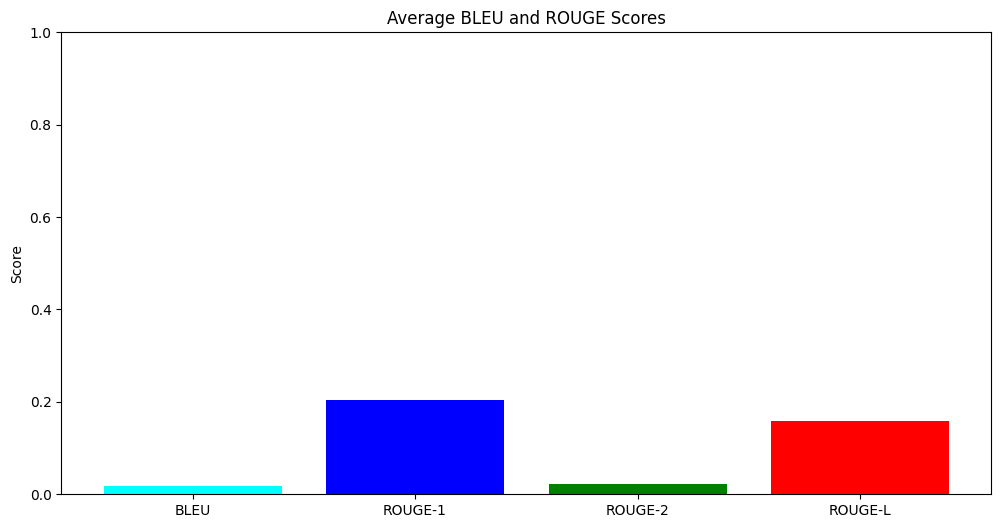

Average BLEU Score: 0.0179
Average ROUGE-1 F1 Score: 0.2051
Average ROUGE-2 F1 Score: 0.0232
Average ROUGE-L F1 Score: 0.1584


In [71]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import numpy as np
import matplotlib.pyplot as plt

def calculate_bleu_scores(actual_summaries, generated_summaries):
    # Calculating BLEU scores for each summary pair
    smoothie = SmoothingFunction().method2
    bleu_scores = [sentence_bleu([actual.split()], generated.split(), smoothing_function=smoothie) for actual, generated in zip(actual_summaries, generated_summaries)]
    return bleu_scores

def calculate_rouge_scores(actual_summaries, generated_summaries):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summaries, actual_summaries, avg=True)
    return rouge_scores

bleu_scores = calculate_bleu_scores(actual_summaries, generated_summaries)
avg_bleu_score = np.mean(bleu_scores)
rouge_scores = calculate_rouge_scores(actual_summaries, generated_summaries)

# Extracting average F1 scores for each ROUGE metric
rouge_1_f1 = rouge_scores['rouge-1']['f']
rouge_2_f1 = rouge_scores['rouge-2']['f']
rouge_l_f1 = rouge_scores['rouge-l']['f']

# Plotting
plt.figure(figsize=(12, 6))
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [avg_bleu_score, rouge_1_f1, rouge_2_f1, rouge_l_f1]

plt.bar(metrics, scores, color=['cyan', 'blue', 'green', 'red'])
plt.title('Average BLEU and ROUGE Scores')
plt.ylabel('Score')
plt.ylim(0, 1) 
plt.show()

# Printing BLEU and ROUGE scores
print(f"Average BLEU Score: {avg_bleu_score:.4f}")
print(f"Average ROUGE-1 F1 Score: {rouge_1_f1:.4f}")
print(f"Average ROUGE-2 F1 Score: {rouge_2_f1:.4f}")
print(f"Average ROUGE-L F1 Score: {rouge_l_f1:.4f}")
